<a href="https://colab.research.google.com/github/mohit1018102/AWS-_ComputerVision_Gluoncv/blob/master/DataScience_in_practice/Tutorials/Linear%20Regression/Tutorial_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Case Study

**Business Need** - Make real-estate investment decision for a large corporation.

**Sub-Problem** - Predict the median house price in a block (smallest census group in US) given other demographic and geographic information.

**For use in** - Other downstream models that need median house price in a block. For example, they may consider a greenfield project. So they need to know what a new block would be.

**Data Science Problem** - Predict a value (the median house price in a block) given several features (other demographic and geographic information.)

It is a supervised learning problem.

**Dataset** - California Census Data with Median Housing Price

In [1]:
# to load file
import pandas as pd;
from google.colab import drive
drive.mount('/content/drive')
df=pd. read_csv("/content/drive/MyDrive/data/housing.csv")
!mkdir /data
df.to_csv('/data/housing.csv',index=False)

Mounted at /content/drive


## Imports and Setting Up

In [2]:
# Generic Imports, Plot Beautification

import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes',labelsize=14)
mpl.rc('xtick',labelsize=12)
mpl.rc('ytick',labelsize=12)

In [3]:
#Setup Figure Saving

fig_dir_path = os.path.join(".","figs")
os.makedirs(fig_dir_path, exist_ok=True)

def save_this(fig_id, tight_layout=True, fig_extension = "png", resolution = 300):
  fig_full_path = os.path.join(fig_dir_path,fig_id+'.'+fig_extension)
  print("saving figure",fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(fig_full_path,dpi=resolution,format=fig_extension)


# Data

Data can be downloaded from [here](https://www.dropbox.com/s/hwnd5h0f0in0jt0/housing.csv?dl=0).

**Familiarize yourself with the tabular data**

Load data from CSV to a dataframe and look at the first 5 rows.

Look at what types are these columns (find their info)

In [6]:
df = pd.read_csv('/data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Q: Find the number of rows and columns of the data frame.


**Task:** Read the column names and try to understand what they mean. If you don't understand, ask the upstream team who provided the data. Ask the data engineer who created the pipeline.

For this case study, we will provide you the meaning of each column:

* <u>longitude, latitude:</u> Geographical location of each block ("district")

* <u>population:</u> Total population in that block.

* <u>households:</u> Total households in that block.

* <u>housing_mean_age:</u> Median age of the households in that block.

* <u>total_room:</u> Total number of rooms in all the houses in that block.

* <u>total_bedroomns:</u> Total number of bedrooms in all the houses in that block.

* <u>median_income:</u> Median income of the households in that block.

* <u>median_house_value:</u> Median value of houses in that block (**this is our Target**)

* <u>ocean_proximity:</u> Categorical variable describing the proximity of that block to the ocean.

In [7]:
df.shape

(20640, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Exploratory Data Analysis

We see that Columns 0-8 are float64 and 9 is an object.

Q: Find the number of unique items in the column "ocean_proximity"

In [10]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Q: Find the descriptive statistics of the numerical values in the table

In [12]:
df.describe() # Finds the mean, std, min, quartiles, max of all numerical values

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Observations

We have explored both numerical and categorical variables and got an understanding of the scale of the data.

<br>
There are some issues to notice:

1. Is ```median_income``` strange?

2. Why do we have ```total_bedrooms``` and ```total_rooms```? Won't bedrooms per house or rooms per house be more useful?

3. How to deal with categorical data?

4. Are longitude and latitude useful?

Indeed, ```median_income``` is strange. <br> First, it seems to be not in simple dollars. Surely, income is not 3.87 dollars on average. And there seems to be a max of 15.0001. You have to enquire with the data provider on why this is the case.

On asking, the upstream team tells you that it is actually in 10k USD and there is an upper cut-off of 150k USD, meaning ```median_income``` is never above 15k USD in this table.

You immediately notice that ```median_house_value``` is also bounded at 500001. So you enquire and understand that ```median_house_value``` is indeed in USD and an upper bound is set.

This latter finding is problematic for you. ```median_house_value``` is our Target, and the training data has artifically imposed a limit on our target. It is a warning sign to be careful.

Now let us look at the distribution of all the numerical values.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

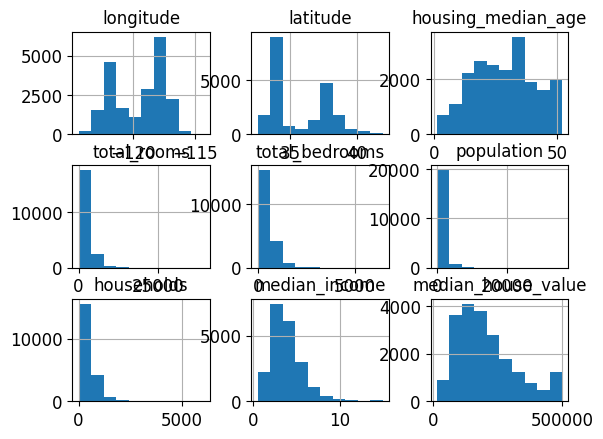

In [22]:
df.hist()

Task: Beautify the histogram plot. Show it in a readable format. Play around with the bin sizes and get it into an interprtable format.

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

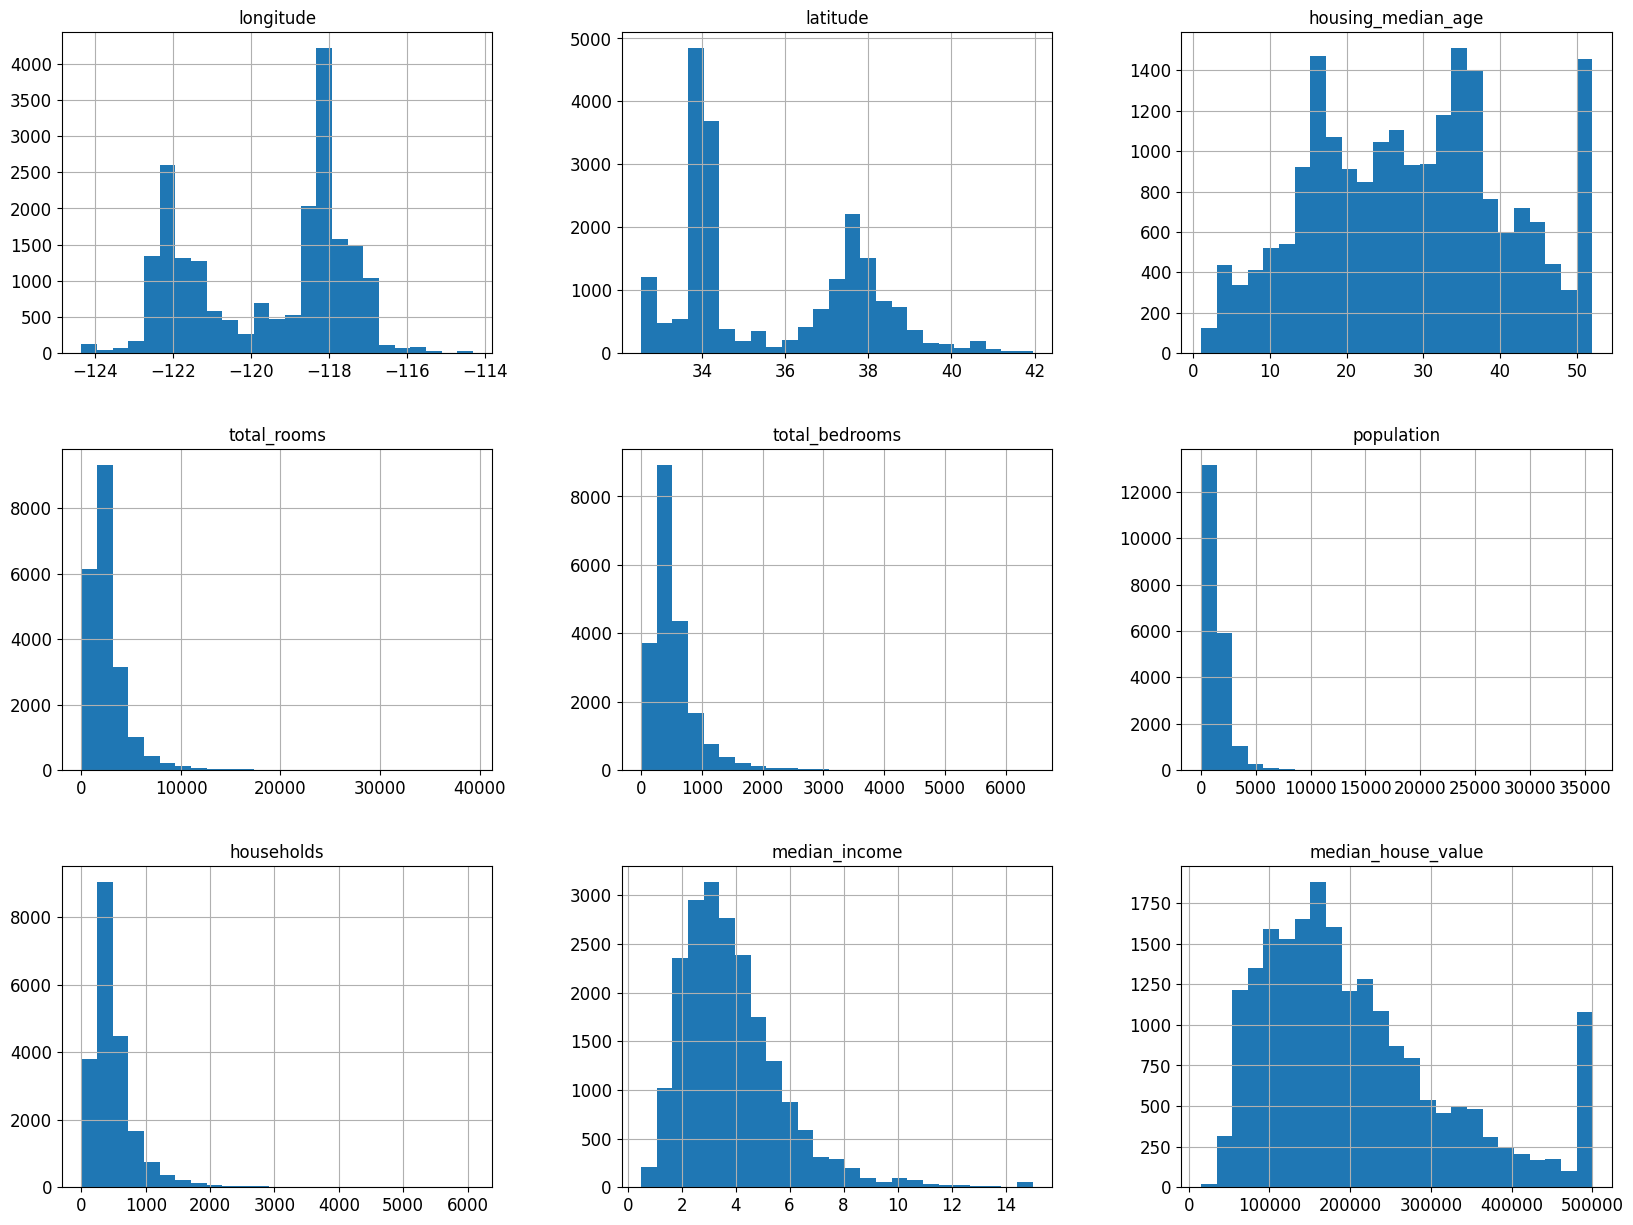

In [23]:
# scale the figure for clearity
df.hist(bins=25,figsize=(20,15))

In [ ]:
# save_this("df_value_histogram")

## Interpret

* Histogram of ```longitude``` and ```latitude``` show that most blocks are concentrated in a few locations. We need geographical plots to see where these locations are.

* Median Housing Age seems to have a upper limit as well at 52. Is it problematic?

* Median House Value has a chunk at the upper limit. This can be a problem. One option is to remove it completely from the dataset, and clarify to downstream teams that our system cannot predict ```median_house_value``` beyond 500000 USD.

Here, we retain and proceed.

# Train-Test Split

Before we proceed further, we must split the dataset into a train (really the train-validate) and test set. The test set is then usually removed from the working environment and saved separately.

We looked at the data attributes and histogram before Train-Test Split is to ensure that our dataset is representative of all targets.

From our above analysis, we do not suspect any non-representativeness (except for >500k USD house price).

Let us do a simple test-train split using sklearn.

In [29]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

```train_test_split``` can work on X, y as well. If the input is X,y instead of df, then ```train_test_split``` returns X_train, X_test, y_train and y_test.

The above splitting is usually enough. But in special cases, we employ what is called as "Stratified Shuffle Split".

Let us say that you did ```train_test_split``` as above, and your upstream data colleague invited you for 11 am coffee. At the coffee shop he tells you, "Pay attention to ```median_income```. I think that ```median_income``` is extremely important for predicting ```median_housing_value```."

So you come back and decide to explore ```median_income``` more.

<Axes: >

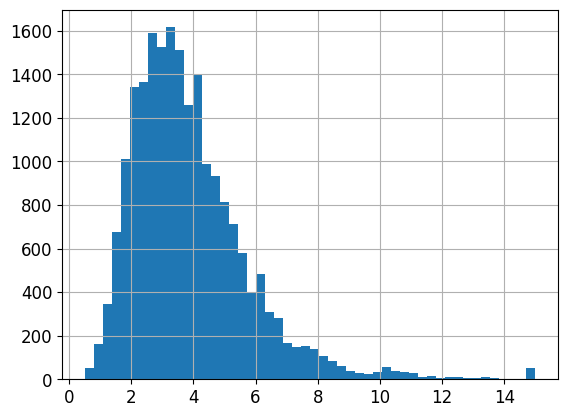

In [30]:
df["median_income"].hist(bins=50)

In [31]:
df["median_income"].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

You see that bulk of the data is between 1.5 (15k) and 6 (60k). This also confirms your understanding of median incomes. So you decide to create bins and categorize income to marginal (0-1.5), low (1.5-3), middle (3-4.5), upper middle (4.5-6), upper classes (6+).

**Task:** Use pandas function ```pd.cut``` and create the above categorization.

**Q: What is the count of each category?**

In [47]:
df["income_cat"] = pd.cut(df["median_income"],bins=[0., 1.5, 3., 4.5, 6., np.inf ], labels=[1, 2, 3, 4, 5])

In [48]:
df["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

Now, we have 5 strata in the dataset. Ideally, we want the ```train_test_split``` to sample in the specified ratio from each strata. For this, we use sklearn's ```stratify``` keyword arg of ```train_test_split```.

Note: Earlier we said that dealing with categorical variables is hard. But now we converted a continuos value to a categorical variable. This conversion helps us in the present application to perform stratifies sampling for ```train_test_split```.

In [49]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42) # No stratification
# create train test split, where we have equal no of distribution. 5 strat
# data is split in a stratified fashion, using this as the class labels
# Stratified splits are desirable in some cases, like when you’re classifying an imbalanced dataset,
# a dataset with a significant difference in the number of samples that belong to distinct classes.
df_train_strat, df_test_strat = train_test_split(df, test_size=0.2, random_state=42, stratify=df["income_cat"])

Let us see the difference in ```value_counts``` proportions in ```df_train``` and ```df_train_strat```

In [50]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

compare_props_train = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(df_train_strat),
    "Random": income_cat_proportions(df_train),
}).sort_index()
# ((random- original)*100)/(original)
compare_props_train["mycal"]= ((compare_props_train["Random"]-compare_props_train["Overall"])*100)/ compare_props_train["Overall"]
compare_props_train["Rand. %error"] = 100 * compare_props_train["Random"] / compare_props_train["Overall"] - 100
compare_props_train["Strat. %error"] = 100 * compare_props_train["Stratified"] / compare_props_train["Overall"] - 100

In [51]:
compare_props_train
# observation strata has less error.
# error   ((actual-expected)*100)/expected

,Overall,Stratified,Random,mycal,Rand. %error,Strat. %error
1,0.039826,0.039789,0.039729,-0.243309,-0.243309,-0.091241
2,0.318847,0.318859,0.317466,-0.433065,-0.433065,0.003799
3,0.350581,0.350594,0.348595,-0.566611,-0.566611,0.003455
4,0.176308,0.176296,0.178537,1.264084,1.264084,-0.006870
5,0.114438,0.114462,0.115673,1.079594,1.079594,0.021169


Now, ideally we must remove ```df_test_strat``` from the notebook and save it as a ```test.csv```. This is an precaution to avoid any kind of accidental data leakage.

If you follow the non-notebook mechanism, a separate cross-validation split is used and train and test csv are built as a first step.

Here, we trust that we will be careful in avoiding data leakage (i.e., test set is somehow used during train-validate).

# Explore train data for ML modelling

In [52]:
df_train_strat.drop("income_cat", axis=1, inplace=True) # income_cat was created for stratified split. Its use is over. Let us remove it.
df_test_strat.drop("income_cat", axis=1, inplace=True)
housing = df_train_strat.copy() # Create a copy to avoid data leakage, and accidental deletion.

**(Optional) Geo Plots**

Since this is a geographical dataset, we can plot the target on a map to visualize. Such visualization can sometimes trigger ideas on what features to use.

We do not plot it here. But you can explore geographical plotting with several resources:
*   https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
*   https://geopandas.org/en/stable/docs/user_guide/mapping.html
*   https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73



## Correlation

Let us see the correlation of all the features with the target

In [53]:
corr_mat = housing.corr()
corr_mat["median_house_value"].sort_values(ascending=False)

<ipython-input-53-d3c698d9482f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = housing.corr()


median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Plot the heat map of the correlation matrix

<Axes: >

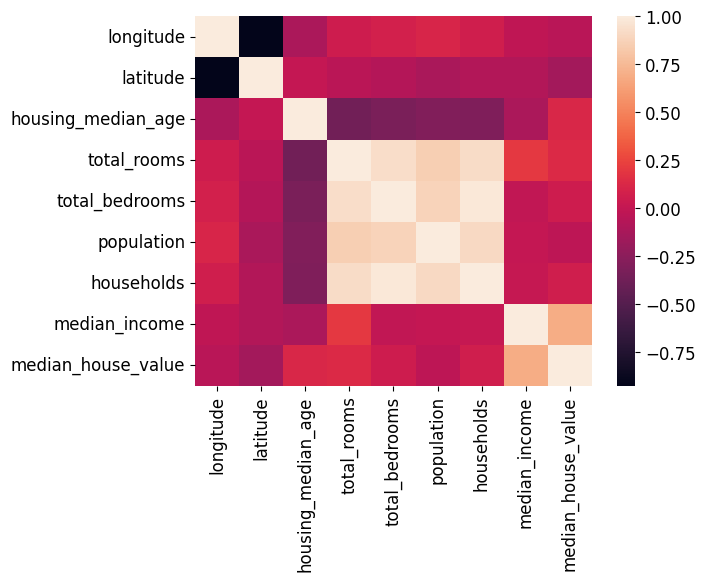

In [54]:
sns.heatmap(corr_mat)

In [55]:
corr_mat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


### Observations

We see that ```median_income``` has the highest correlation with ```median_house_value``` as our friend had suggested. We already did a smart move - of stratified sampling.

We also note that ```latitude``` has a negative correlation with house value. Its implication is that moving north reduces the house value.

```population``` has a slightly negative correlation as expected.

<br>
Let us look at a few more visualizations of the data.

**Task 1:** Plot the scatter of ```median_house_vale```, ```median_income```, ```total_rooms```, ```housing_median_age``` using seaborn

<Axes: xlabel='median_income', ylabel='total_rooms'>

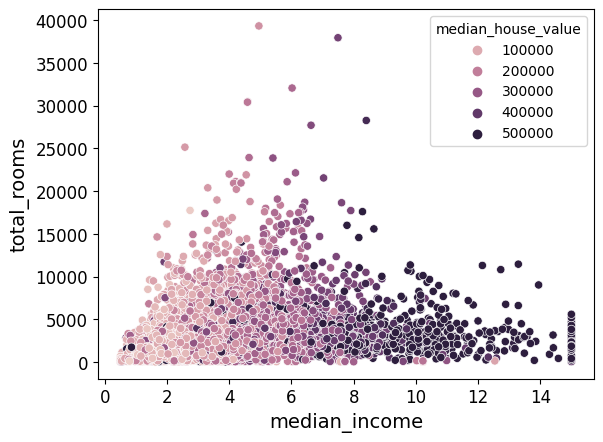

In [57]:
sns.scatterplot(data=housing, x="median_income", y="total_rooms", hue="median_house_value")

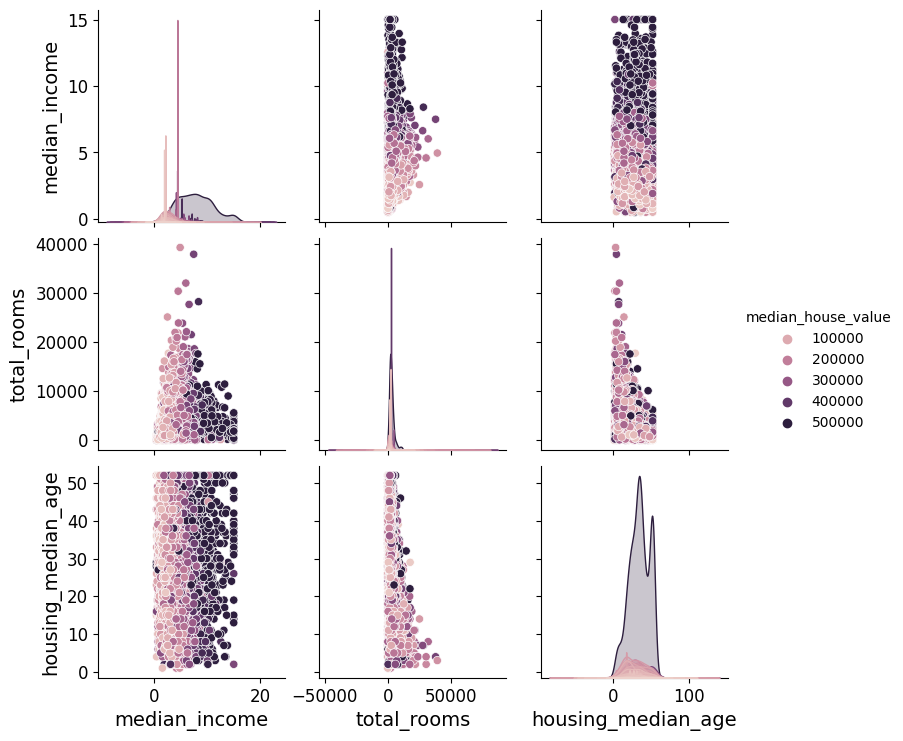

In [58]:
cols_needed = ["median_income","total_rooms","housing_median_age","median_house_value"]
sns.pairplot(data=housing[cols_needed], hue="median_house_value") # This will take some time

This phase is to fire your brain to think of possible combinations for feature engieering. You must use your business knowledge (or process, science, domain knowledge) to figure out what features are important for this problem.

## Feature Engineering

The strange issue here is that ```total_rooms``` and ```total_bedrooms``` are not as correlated with ```median_house_value```. In fact, our intutition suggests that 3BHK is more pricier than 2BHK etc. So we should look at rooms and bedroom per household.

</br>
Let us do that feature engineering.

**Task:** Add new features of ```rooms_per_house``` and ```bedrooms_per_house```

**Q: What is the correlation of the new features to the target.**

In [59]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_house"] = housing["total_bedrooms"]/housing["households"]
corr_mat2 = housing.corr()
corr_mat2["median_house_value"].sort_values(ascending=False)

<ipython-input-59-b2db7e9ea64f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat2 = housing.corr()


median_house_value    1.000000
median_income         0.687151
rooms_per_house       0.146255
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
bedrooms_per_house   -0.043349
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Not much changed. Let us try different combinations of rooms.

Next on list:
*   ```bedrooms_per_room``` : what fraction of room is bedroom.
*   ```population_per_house```

In [62]:
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_house"] = housing["population"]/housing["households"]
corr_mat3 = housing.corr()
corr_mat3["median_house_value"].sort_values(ascending=False)

<ipython-input-62-f397b47466fc>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat3 = housing.corr()


median_house_value      1.000000
median_income           0.687151
rooms_per_house         0.146255
total_rooms             0.135140
housing_median_age      0.114146
households              0.064590
total_bedrooms          0.047781
population_per_house   -0.021991
population             -0.026882
bedrooms_per_house     -0.043349
longitude              -0.047466
latitude               -0.142673
bedrooms_per_room      -0.259952
Name: median_house_value, dtype: float64

OK! ```bedrooms_per_room``` is more correlated (-vely) with house value. Apparently houses with more bedrooms cost less. Somehow people seem to value houses with more non-bedrooms here.

**Message:** We have identified that ```median_income```, ```bedrooms_per_room``` and ```rooms_per_house``` (or ```total_rooms```), ```housing_median_age``` seem to be good predictors for ```house_value```. ```latitude``` is also correlated, but it seems to be strange to include that as a predictor.

We still have to worry about missing data and handling categorical data.

Now we are entering the stage of preparing the data for ML.

Remember we need X and y for ML.

# Prepare Data for ML

In [63]:
hml = df_train_strat.drop("median_house_value", axis=1) # drop labels for training set
hml_labels = df_train_strat["median_house_value"].copy()
# Note: Here we did not use the housing df as above. We have modified housing df for exploration purposes. We will use that learning in creating an automatic data processing pipeline soon.

## Handle Missing Data

**Q: How many data points are missing? What featues are missing?**

In [64]:
hml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


```total_bedrooms``` has some missing values. We have to handle this.

Missing Values are handled using an imputer.

Imputation is a statistical process of replacing null values (missing values) with statistics of the available values. In advanced applications, we even use another ML model (say regression, or RF) as an imputer. See [this](https://en.wikipedia.org/wiki/Imputation_(statistics)).

In this particular case, the number of missing entries are small, and only the ```total_bedrooms``` feature is missing. So either we can drop the rows where the ```total_bedrooms``` is missing; or we can drop the feature ```total_bedrooms```.

If we don't want to lose valuable datapoints, typically, we use replacement with mean or median as an imputer. Here, we will simply use ```median``` and ```sklearn.impute.SimpleImputer```

```SimpleImputer``` with median only works with numerical data.

So we will only use numerical data to perform the imuptation

In [66]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

hml_num = hml.drop("ocean_proximity", axis=1)

imputer.fit(hml_num)

X = imputer.transform(hml_num) # Imputer returns a numpy array. So we need to transform it back to a pandas df

hml_num_tr = pd.DataFrame(data=X, columns=hml_num.columns, index=hml_num.index)

In [67]:
hml_num_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


So far, so good. We have successfully removed the ```nan``` entries. You can verify if everything went correct by looking at the rows with ```nan``` entries in ```hml``` and corresponding rows in ```hml_num_tr```.

Before we deal with categorical data, let us add the features we engineered.

In [69]:
hml_num_tr["bedrooms_per_room"] = hml_num_tr["total_bedrooms"]/hml_num_tr["total_rooms"]
hml_num_tr["bedrooms_per_house"] = hml_num_tr["total_bedrooms"]/hml_num_tr["households"]
hml_num_tr["rooms_per_house"] = hml_num_tr["total_rooms"]/hml_num_tr["households"]

## Handle Categorical Data

Ocean Proximity is a categorical variable. It must be handled.

There are several ways to handle catergorical data. We will use a popular technique called as ```OneHotEncoder```.

We can use ```sklearn.preprocessing.OneHotEncoder```

Alternatively we can use ```pandas.get_dummies```. See [this](https://towardsdatascience.com/what-is-one-hot-encoding-and-how-to-use-pandas-get-dummies-function-922eb9bd4970)

In [71]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

hml_cat = hml[["ocean_proximity"]] # Use two square brackets as fit_transform expects a df. With singe square bracket, a series is returned

hml_cat_1hot = cat_encoder.fit_transform(hml_cat)

In [72]:
hml_cat_1hot

# this is a sparse array. We must use .toarray() to convert into a full matrix that can be concatenated to the numerical features.

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [73]:
X_train = np.concatenate([hml_num_tr.to_numpy(), hml_cat_1hot.toarray()], axis=1)

y_train = hml_labels.values

In [74]:
X_train

array([[-121.46,   38.52,   29.  , ...,    0.  ,    0.  ,    0.  ],
       [-117.23,   33.09,    7.  , ...,    0.  ,    0.  ,    1.  ],
       [-119.04,   35.37,   44.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [-122.72,   38.44,   48.  , ...,    0.  ,    0.  ,    0.  ],
       [-122.7 ,   38.31,   14.  , ...,    0.  ,    0.  ,    0.  ],
       [-122.14,   39.97,   27.  , ...,    0.  ,    0.  ,    0.  ]])

## Scaling

We observed that the features have different scales. So, we perform a standard scaling operation to bring all data to the same scale.

Usually, targets don't need to be scaled. There is no harm in scaling the target separately, but we don't do it.

**Task:** Use ```sklearn.preprocessing.StandardScaler```

In [103]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# uses X-meam/ std.dev

X_train_scl = scaler.fit_transform(X_train)

With this, we have the ```X_train_scl``` and ```y_train``` that can be used for machine learning.

This ```X_train``` does not have the new features that we engineered.

But, we have done a lot of work to transform our dataframe to features. We must do the same for future data, including test data.

For this purpuse, we create a "pipeline" and use "custom_transformation"

# Custom Transformation and Pipeline

1. Handle missing numerical data
2. Add new features columns
3. Handled the categorical data
4. Scale

**First**: Create a custom transformation to add new attribute through feature combinations

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = ["total_rooms","total_bedrooms","population","households"]

rooms_indx, bedrooms_indx, pop_indx, house_indx = [housing.columns.get_loc(ii) for ii in col_names] # We are using Python list comprehension

class EngineeredFeatureAdder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    rooms_per_household = X[:,rooms_indx]/X[:,house_indx]
    bedrooms_per_household = X[:,bedrooms_indx]/X[:,house_indx]
    population_per_household = X[:,pop_indx]/X[:,house_indx]
    bedrooms_per_room = X[:,bedrooms_indx]/X[:,rooms_indx]
    return np.c_[X, rooms_per_household, bedrooms_per_household, population_per_household, bedrooms_per_room]

# Note: Here, we are adding all engineered features. This is probably not a good idea. We are simply showing an example.

The input to the custom transformer ```EngineeredFeatureAdder``` is a numpy array. We cannot pass in a pandas dataframe here.

If we need a pandas dataframe later, then we have to create a pipeline with a ```pandasizer```, a function that takes the output of the cusomt transformer and returns a pandas df.

**Exercise:** Create a pipeline with a pandasizer

# Transformation Pipeline

Build a pipeline for the numerical attributes, and categorical attributes separately.

Then we will combine them together using column transformer

We must impute and scale.



In [86]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# numerical
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('feat_eng', EngineeredFeatureAdder()),
                         ('scaler', StandardScaler())
                         ])

# categorical
cat_pipeline = Pipeline([
                         ('encoder', OneHotEncoder())
                         ])

from sklearn.compose import ColumnTransformer

num_cols = list(hml_num) # Alternatively: hml_num.columns.values.tolist()
cat_cols = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)
                                   ])

hml_prepared = full_pipeline.fit_transform(hml)

# ML Modelling

In [99]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(hml_prepared, hml_labels)

LinearRegression()

In [100]:
from sklearn.metrics import mean_squared_error

hml_test = df_test_strat.drop("median_house_value", axis=1) # drop labels for training set
hml_test_labels = df_test_strat["median_house_value"].copy()

X_test = full_pipeline.transform(hml_test)
y_test_predict = lin_reg.predict(X_test)

mean_squared_error(hml_test_labels, y_test_predict, squared=False)

66949.14501420947

In [101]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, hml_prepared, hml_labels, scoring="neg_mean_squared_error", cv=5)

In [102]:
np.sqrt(-scores)

array([67893.03245703, 67357.29951844, 69747.12110996, 69605.82481702,
       67944.54884917])

# Fine-tune your model

The ```cross_val_score``` shows that the training is stable. The validation error is not varying widely.

For linear regression, there is no further hyper-parameter tuning.

But if we go for ```ElasticNet```, or Random Forest, or ```XGBoost``` there is hyper-parameter tuning.

Hyper-parameter tuning can be done with ```GridSearchCV``` or ```RandomizedSearchCV```

In [98]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

enet = ElasticNet()

params = {'alpha': [0.1, 1, 10, 100], 'l1_ratio': [0.25, 0.5, 0.75]}

regressor = GridSearchCV(enet, params, cv=5)

regressor.fit(hml_prepared, hml_labels)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 10, 100],
                         'l1_ratio': [0.25, 0.5, 0.75]})

In [93]:
regressor.best_params_

{'alpha': 0.1, 'l1_ratio': 0.75}

In [94]:
regressor.cv_results_

{'mean_fit_time': array([0.05471206, 0.06315556, 0.09757009, 0.0238286 , 0.02384062,
        0.03475957, 0.00748281, 0.00859671, 0.0115932 , 0.00985985,
        0.01112266, 0.00662742]),
 'std_fit_time': array([0.01675259, 0.00312648, 0.00810181, 0.00192607, 0.0012402 ,
        0.00456906, 0.00022594, 0.00183372, 0.0063177 , 0.00325769,
        0.00431673, 0.0004447 ]),
 'mean_score_time': array([0.002385  , 0.00189996, 0.00192294, 0.00174265, 0.00189762,
        0.00194182, 0.00111594, 0.00109677, 0.00194306, 0.0014154 ,
        0.0013638 , 0.00107188]),
 'std_score_time': array([8.51943863e-04, 2.90883369e-04, 4.51593202e-04, 3.57172243e-04,
        2.79701898e-04, 1.73458297e-04, 3.54398131e-05, 4.96388169e-05,
        1.24292857e-03, 2.85322103e-04, 3.32032995e-04, 4.80798479e-05]),
 'param_alpha': masked_array(data=[0.1, 0.1, 0.1, 1, 1, 1, 10, 10, 10, 100, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False

The best hyper-parameter set can be found from the CV results and used to train a best model.

Setting the parameter ```refit=True``` will automatically do the refit for you.

Or you can decide to pick the best three models and create an ensemble.

In [95]:
best_model = ElasticNet(alpha=0.1,l1_ratio=0.75)

best_model.fit(hml_prepared,hml_labels)

ElasticNet(alpha=0.1, l1_ratio=0.75)

In [96]:
hml_test = df_test_strat.drop("median_house_value", axis=1) # drop labels for training set
hml_test_labels = df_test_strat["median_house_value"].copy()
X_test = full_pipeline.transform(hml_test)
y_test_predict = best_model.predict(X_test)
mean_squared_error(hml_test_labels,y_test_predict,squared=False)


67387.10585239419

# Conclusion

The error is slightly on the higher side. An average error of 67k USD might not be acceptable for house values.

Further modeling, feature engineering, and discussions with stakeholders is needed before finalizing a model for this study.

In [97]:
from IPython.display import clear_output



clear_output()